In [2]:
#Importing the necessary library

import sqlite3 as db
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt

#Making connection to database
conn = db.connect("olist.db")

#Showing table names inside the database
df_tables = pd.read_sql_query (
"""
SELECT name FROM sqlite_master WHERE type = 'table';
"""
,conn)

df_tables

,name
0,olist_order_customer_dataset
1,olist_order_dataset
2,olist_order_reviews_dataset
3,olist_order_payments_dataset
4,olist_order_items_dataset
5,olist_products_dataset
6,olist_sellers_dataset
7,olist_geolocation_dataset
8,product_category_name_translation


In [29]:
#Assigning each table to variable

order_customer = pd.read_sql_query("""SELECT * FROM olist_order_customer_dataset;""", conn)
order = pd.read_sql_query("""SELECT * FROM olist_order_dataset;""", conn)
order_reviews = pd.read_sql_query("""SELECT * FROM olist_order_reviews_dataset;""", conn)
order_payments = pd.read_sql_query("""SELECT * FROM olist_order_payments_dataset;""", conn)
order_items = pd.read_sql_query("""SELECT * FROM olist_order_items_dataset;""", conn)
products = pd.read_sql_query("""SELECT * FROM olist_products_dataset;""", conn)
sellers = pd.read_sql_query("""SELECT * FROM olist_sellers_dataset;""", conn)
geolocation = pd.read_sql_query("""SELECT * FROM olist_geolocation_dataset;""", conn)
product_category_name_translation = pd.read_sql_query("""SELECT * FROM product_category_name_translation;""", conn)

In [4]:
#Checking null in each table

#Making an empty dataframe to store the tables
null_table = pd.DataFrame()

#Making a list consist of table name
null_item = [order_customer, order, order_reviews, order_payments, order_items, products, sellers, geolocation]
column_name = ["order_customer", "order", "order_reviews", "order_payments", "order_items","products", "sellers", "geolocation"]

#Using loop to iterate through all table, find all columns that ontain null values, and store the null values into null_table
for item in null_item:
    null_table = pd.concat([null_table, item.isnull().sum()], ignore_index=True, axis = 1)
null_table.columns = column_name

#Show null table, but only the table and columns that contain null values
#by dropping all Na (in the null table, Na means the data has 0 null values)
null_table.replace(0, None).dropna(how="all").fillna(0)

,order_customer,order,order_reviews,order_payments,order_items,products,sellers,geolocation
order_approved_at,0,160.0,0.0,0,0,0.0,0,0
order_delivered_carrier_date,0,1783.0,0.0,0,0,0.0,0,0
order_delivered_customer_date,0,2965.0,0.0,0,0,0.0,0,0
review_comment_title,0,0.0,87656.0,0,0,0.0,0,0
review_comment_message,0,0.0,58247.0,0,0,0.0,0,0
product_category_name,0,0.0,0.0,0,0,610.0,0,0
product_name_lenght,0,0.0,0.0,0,0,610.0,0,0
product_description_lenght,0,0.0,0.0,0,0,610.0,0,0
product_photos_qty,0,0.0,0.0,0,0,610.0,0,0
product_weight_g,0,0.0,0.0,0,0,2.0,0,0


In [8]:
#Finding the reason for null values inside order table

order_canceled = pd.read_sql_query(
    """SELECT order_status, 
    SUM(CASE WHEN order_approved_at is NULL THEN 1 ELSE 0 END) as null_approved,
    SUM(CASE WHEN order_delivered_carrier_date is NULL THEN 1 ELSE 0 END) as null_deliv_carrier,
    SUM(CASE WHEN order_delivered_customer_date is NULL THEN 1 ELSE 0 END) as null_deliv_cust
    FROM olist_order_dataset
    GROUP BY order_status;"""
,conn)
order_canceled

,order_status,null_approved,null_deliv_carrier,null_deliv_cust
0,approved,0,2,2
1,canceled,141,550,619
2,created,5,5,5
3,delivered,14,2,8
4,invoiced,0,314,314
5,processing,0,301,301
6,shipped,0,0,1107
7,unavailable,0,609,609


In [9]:
#Filling the null value inside order table

#Make cursor from the connection
cursor = conn.cursor()

#Make a temporary table and use coalesce to fill the null value
cursor.execute ("""
CREATE TEMPORARY TABLE cleaned_olist_order_dataset AS
SELECT  order_id,
        customer_id,
        order_status,
        order_purchase_timestamp,
        COALESCE(order_approved_at, "1999-01-01 00:00:00") as order_approved_at,
        COALESCE(order_delivered_carrier_date, "1999-01-01 00:00:00") as order_delivered_carrier_date,
        COALESCE(order_delivered_customer_date, "1999-01-01 00:00:00") as order_delivered_customer_date,
        order_estimated_delivery_date
FROM olist_order_dataset;
""")

#Drop the real table that still contains the null value
cursor.execute("""
DROP TABLE olist_order_dataset;
""")

#Rename the temporary table into the original table name 
cursor.execute("""
ALTER TABLE cleaned_olist_order_dataset RENAME TO olist_order_dataset;
""")

conn.commit()

In [10]:
#Filling the null value inside order reviews table

#Make a temporary table and use coalesce to fill the null value
cursor.execute ("""
CREATE TEMPORARY TABLE cleaned_olist_order_reviews_dataset AS
SELECT  review_id,
        order_id,
        review_score,
        COALESCE(review_comment_title, "no review") as review_comment_title,
        COALESCE(review_comment_message, "no review") as review_comment_message,
        review_creation_date,
        review_answer_timestamp
FROM olist_order_reviews_dataset;
""")

#Drop the real table that still contains the null value
cursor.execute("""
DROP TABLE olist_order_reviews_dataset;
""")

#Rename the temporary table into the original table name 
cursor.execute("""
ALTER TABLE cleaned_olist_order_reviews_dataset RENAME TO olist_order_reviews_dataset;
""")

conn.commit()

In [17]:
order.head()

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [24]:
#Checking if there's an order on item with null category name

product_id_check = pd.read_sql_query(
    """SELECT   
        oi.order_id, product_id, o.order_purchase_timestamp,
        MAX(o.order_purchase_timestamp) OVER() as max_date_ordered
    FROM olist_order_items_dataset oi
    JOIN olist_order_dataset o
    USING(order_id)
    WHERE product_id IN (SELECT product_id FROM olist_products_dataset WHERE product_category_name is NULL)
    ORDER BY o.order_purchase_timestamp DESC;"""
,conn)
product_id_check.head(10)

,order_id,product_id,order_purchase_timestamp,max_date_ordered
0,e6f6345c50327507fe35965aa65c8e94,fd85f34d70edf41fbea6a3269d183e00,2018-08-27 18:50:06,2018-08-27 18:50:06
1,e53249d8b27242c64053f94e2af2b2ba,b0645512783cc56c9510f08e90a40ede,2018-08-26 21:18:34,2018-08-27 18:50:06
2,f2fc3e958c7943badc989a1f5db932b4,6ab9d49c399f239bc88ea28c7568213f,2018-08-22 21:25:12,2018-08-27 18:50:06
3,9c33774fba00c73b651903f988c71bb9,f524a09994004b2dabb3d13cf1a041fb,2018-08-20 12:37:12,2018-08-27 18:50:06
4,61eedf8710394769412bccced6288fff,5a848e4ab52fd5445cdc07aab1c40e48,2018-08-20 09:45:10,2018-08-27 18:50:06
5,fa9aefedb556db70fd8ca7a716f79802,76d1a1a9d21ab677a61c3ae34b1b352f,2018-08-19 23:05:53,2018-08-27 18:50:06
6,94896a982ee16e53abdc889d32f289ba,b77b1c083bc9bd1bbceccc2346cd02f4,2018-08-18 13:37:04,2018-08-27 18:50:06
7,15008182975b6283817426f03e9f79a7,bfa0e398bef2d28bb421d42997982cab,2018-08-17 22:29:33,2018-08-27 18:50:06
8,6616fa4c89b8bf2a7e17271cdc542fca,fc5dd987f12a7b823a76a44aa1ba88f6,2018-08-17 20:47:06,2018-08-27 18:50:06
9,0e259b373316a562c9e71cd725ce1120,4d2481b021cc6916e6c45615ee2d7638,2018-08-17 10:32:19,2018-08-27 18:50:06


In [27]:
#Checking the mode for these three column to fill the number inside the null values

product_name_mode = products["product_name_lenght"].mode()[0]
product_desc_mode = products["product_description_lenght"].mode()[0]
product_photos_mode = products["product_photos_qty"].mode()[0]

print(f'Product Name Length Mode : {product_name_mode}')
print(f'Product Description Length Mode : {product_desc_mode}')
print(f'Product Photos Quantity Mode : {product_photos_mode}')

Product Name Length Mode : 60.0
Product Description Length Mode : 404.0
Product Photos Quantity Mode : 1.0


In [28]:
#Filling the null value inside order table

#Make a temporary table and use coalesce to fill the null value
#Dropping the two product that have null values in product weight, length, height, and width
cursor.execute ("""
CREATE TEMPORARY TABLE cleaned_olist_products_dataset AS
SELECT  product_id,
        COALESCE(product_category_name, "unknown") as product_category_name,
        COALESCE(product_name_lenght, 60) as product_name_length,
        COALESCE(product_description_lenght, 404) as product_description_length,
        COALESCE(product_photos_qty, 1) as product_photos_qty,
        product_weight_g,
        product_length_cm,
        product_height_cm,
        product_width_cm

FROM olist_products_dataset
WHERE product_weight_g IS NOT NULL;
""")

#Drop the real table that still contains the null value
cursor.execute("""
DROP TABLE olist_products_dataset;
""")

#Rename the temporary table into the original table name 
cursor.execute("""
ALTER TABLE cleaned_olist_products_dataset RENAME TO olist_products_dataset;
""")

conn.commit()

In [30]:
#Checking null in each table after cleaning

#Making an empty dataframe to store the tables
null_table = pd.DataFrame()

#Making a list consist of table name
null_item = [order_customer, order, order_reviews, order_payments, order_items, products, sellers, geolocation]
column_name = ["order_customer", "order", "order_reviews", "order_payments", "order_items","products", "sellers", "geolocation"]

#Using loop to iterate through all table, find all columns that ontain null values, and store the null values into null_table
for item in null_item:
    null_table = pd.concat([null_table, item.isnull().sum()], ignore_index=True, axis = 1)
null_table.columns = column_name

#Show null table, but only the table and columns that contain null values
#by dropping all Na (in the null table, Na means the data has 0 null values)
null_table.replace(0, None).dropna(how="all").fillna(0)

,order_customer,order,order_reviews,order_payments,order_items,products,sellers,geolocation


In [31]:
#Checking duplicate in each table

#Making an empty dataframe to store the tables
duplicated_table = pd.DataFrame()

#Making a list consist of table name
duplicated_item = [order_customer, order, order_reviews, order_payments, order_items, products, sellers, geolocation]
column_name = ["order_customer", "order", "order_reviews", "order_payments", "order_items","products", "sellers", "geolocation"]

#Using loop to iterate through all table, find all columns that contain duplicate values, and store the duplicate
#values into duplicated_table
for item in duplicated_item:
    duplicated_table = pd.concat([duplicated_table, item.duplicated()], ignore_index=True, axis = 1)
duplicated_table.columns = column_name

#Show any table that have a duplicated_value
duplicated_table.any()

order_customer    False
order             False
order_reviews     False
order_payments    False
order_items       False
products          False
sellers           False
geolocation       False
dtype: bool

In [ ]:
#BEST AND WORST SELLING CATEGORY

In [33]:
#Use query to find the number of order per category while joining the translation table

num_order_per_category = pd.read_sql_query(
    """
    SELECT product_category_name_english as category_name, COUNT(o.order_id) as num_of_order FROM olist_products_dataset p
    JOIN olist_order_items_dataset oi
    ON p.product_id = oi.product_id
    JOIN olist_order_dataset o
    ON oi.order_id = o.order_id
    JOIN product_category_name_translation pcn
    ON p.product_category_name = pcn.product_category_name
    GROUP BY 1
    ORDER BY 2 DESC
    """
, conn)

num_order_per_category.head()

,category_name,num_of_order
0,bed_bath_table,11115
1,health_beauty,9670
2,sports_leisure,8641
3,furniture_decor,8334
4,computers_accessories,7827


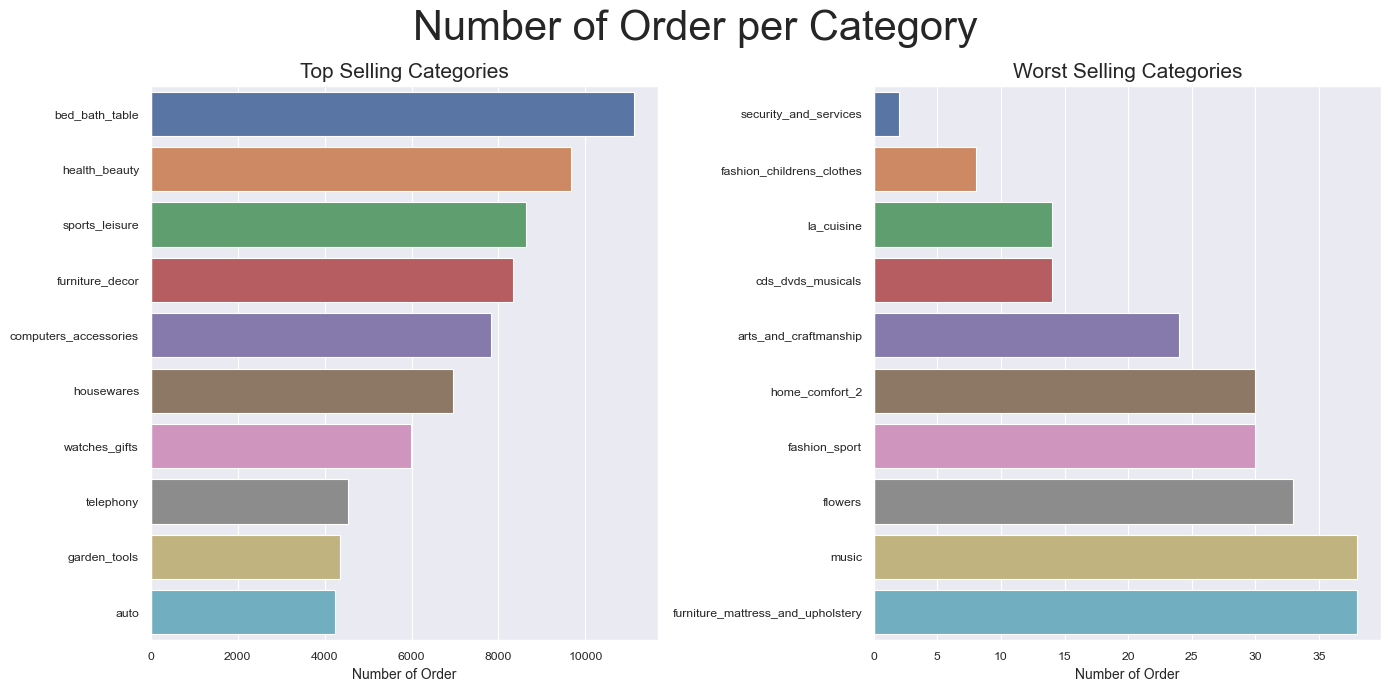

In [51]:
#Making the plots

sns.set_theme(style = "darkgrid", context = "paper")

#Making data that contain top and bottom category
top_category = num_order_per_category[:10]
bottom_category = num_order_per_category[-10:].sort_values(by="num_of_order")

#Decalring the subplots 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14,7))

#Making barplot for top 10 category
sns.barplot(data = top_category, x="num_of_order", y="category_name", orient = "h", ax = ax[0])
ax[0].set_title("Top Selling Categories", fontsize = 15)
ax[0].set_xlabel("Number of Order", fontsize = 10)
ax[0].set_ylabel("")

#Making barplot for bottom 10 category
sns.barplot(data = bottom_category, x="num_of_order", y="category_name", orient = "h", ax = ax[1])
ax[1].set_title("Worst Selling Categories", fontsize = 15)
ax[1].set_xlabel("Number of Order", fontsize = 10)
ax[1].set_ylabel("")

plt.suptitle("Number of Order per Category", fontsize = 30)
plt.tight_layout()
plt.show()

In [ ]:
#PRICE AND FREIGHT VALUE VS NUMBER OF ORDERS

In [58]:
#Make sure the price and freight value is in float/int type
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   index                112650 non-null  int64  
 1   order_id             112650 non-null  object 
 2   order_item_id        112650 non-null  int64  
 3   product_id           112650 non-null  object 
 4   seller_id            112650 non-null  object 
 5   shipping_limit_date  112650 non-null  object 
 6   price                112650 non-null  float64
 7   freight_value        112650 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 6.9+ MB


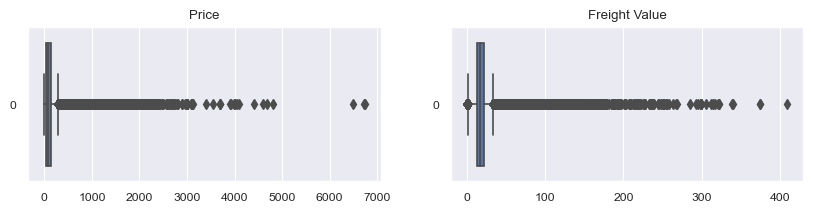

In [57]:
#Making boxplot to check outlier in price and freight value

#Declaring the subplots
figure, ax = plt.subplots(1,2, figsize = (10,2))

#Making boxplot for price and freight value
sns.boxplot(order_items["price"], orient = "h", ax=ax[0])
ax[0].set_title("Price")
sns.boxplot(order_items["freight_value"], orient = "h", ax = ax[1])
ax[1].set_title("Freight Value")
plt.show()

In [38]:
#Using IQR to filter outlier


#Find Q1, Q3, and IQR
q1 = order_items["price"].quantile(0.25)
q3 = order_items["price"].quantile(0.75)
IQR = q3-q1

#Max value as threshold, data above the max value will be deleted
max_value = q3+1.5*IQR

#Filtering the data that's above max value
order_items_cleaned_p = order_items.loc[order_items["price"]<max_value]
order_items_cleaned_p.head()

,index,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [39]:
#Checking the distribution of data after cleaning

order_items_cleaned_p["price"].describe()

count    104223.000000
mean         83.974668
std          58.580002
min           0.850000
25%          38.500000
50%          69.000000
75%         118.990000
max         277.300000
Name: price, dtype: float64

In [40]:
#Using IQR to filter outlier

#Find Q1, Q3, and IQR
q1 = order_items["freight_value"].quantile(0.25)
q3 = order_items["freight_value"].quantile(0.75)
IQR = q3-q1

#Max value as threshold, data above the max value will be deleted
max_value = q3+1.5*IQR

#Filtering the data that's above max value
order_items_cleaned_fv = order_items.loc[order_items["freight_value"]<max_value]
order_items_cleaned_fv.head()

,index,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [41]:
#Checking the distribution of data after cleaning

order_items_cleaned_fv["freight_value"].describe()

count    101037.000000
mean         16.042887
std           5.574386
min           0.000000
25%          12.700000
50%          15.580000
75%          18.780000
max          33.250000
Name: freight_value, dtype: float64

<AxesSubplot: >

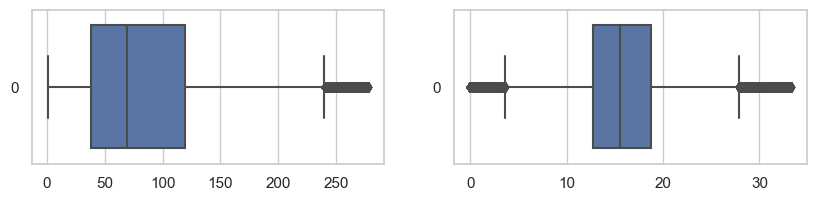

In [42]:
#Making boxplot to check outlier in price and freight value after cleaning

figure, ax = plt.subplots(1,2, figsize = (10,2))

sns.boxplot(order_items_cleaned_p["price"], orient = "h", ax=ax[0])
sns.boxplot(order_items_cleaned_fv["freight_value"], orient = "h", ax = ax[1])

In [43]:
#Slicing price into intervals

# Define the intervals
bins = [x for x in range(0,300,20)]
label = [f"{x} to {x+20}" for x in range(0,280,20)]

# Create a new column for the interval labels
order_items_cleaned_p['price_interval'] = pd.cut(order_items_cleaned_p["price"], bins, labels = label)

# Count the number of orders in each interval
interval_counts_p = order_items_cleaned_p['price_interval'].value_counts().sort_index()

# Print the result
print(interval_counts_p)


0 to 20        9401
20 to 40      20165
40 to 60      19152
60 to 80      12163
80 to 100     11456
100 to 120     8176
120 to 140     6217
140 to 160     5440
160 to 180     3768
180 to 200     3338
200 to 220     1635
220 to 240     1388
240 to 260     1349
260 to 280      575
Name: price_interval, dtype: int64


C:\Users\Eko Yuswanto\AppData\Local\Temp\ipykernel_17632\572265466.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_items_cleaned_p['price_interval'] = pd.cut(order_items_cleaned_p["price"], bins, labels = label)


In [60]:
#Slicing freight value into intervals

# Define the intervals
bins = [x for x in range(0,36,2)]
label = [f"{x} to {x+2}" for x in range(0,34,2)]

# Create a new column for the interval labels
order_items_cleaned_fv['freight_value_interval'] = pd.cut(order_items_cleaned_fv["freight_value"], bins, labels = label)

# Count the number of orders in each interval
interval_counts_fv = order_items_cleaned_fv['freight_value_interval'].value_counts().sort_index()

# Print the result
print(interval_counts_fv)

0 to 2        283
2 to 4        386
4 to 6        350
6 to 8       6534
8 to 10      7962
10 to 12     6311
12 to 14    11564
14 to 16    19387
16 to 18    15955
18 to 20    12350
20 to 22     5112
22 to 24     5401
24 to 26     3087
26 to 28     3065
28 to 30     1489
30 to 32      911
32 to 34      507
Name: freight_value_interval, dtype: int64


C:\Users\Eko Yuswanto\AppData\Local\Temp\ipykernel_17632\3043138450.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_items_cleaned_fv['freight_value_interval'] = pd.cut(order_items_cleaned_fv["freight_value"], bins, labels = label)


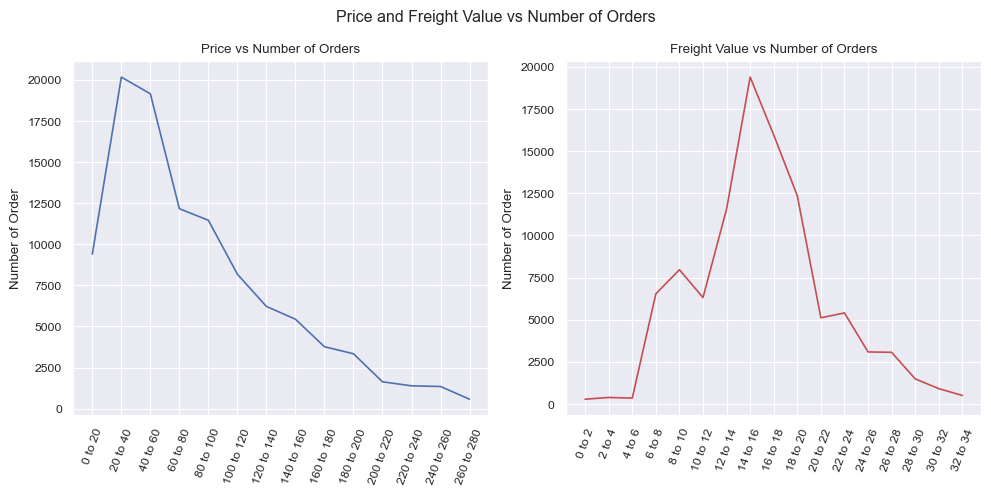

In [59]:
#Making the plot for price and freight value vs num of orders

#Declaring the subplots and size
fig, ax = plt.subplots(1,2, figsize = (10,5))

#Making the first line plot for price
sns.lineplot(interval_counts_p, ax = ax[0], color = 'b')
ax[0].set_ylabel("Number of Order")
ax[0].set_xlabel("")
ax[0].set_title("Price vs Number of Orders")
ax[0].tick_params(axis = 'x', rotation = 70)

#Making the second line plot for freight value
sns.lineplot(interval_counts_fv, ax = ax[1], color='r')
ax[1].set_ylabel("Number of Order")
ax[1].set_xlabel("")
ax[1].set_title("Freight Value vs Number of Orders")
ax[1].tick_params(axis = 'x', rotation = 70)

plt.suptitle("Price and Freight Value vs Number of Orders")
plt.tight_layout()
plt.show()

In [ ]:
#CATEGORY WITH MOST REPEAT ORDERS

In [ ]:
#Use query to make a table that contain repeat order per product

repeat_order = pd.read_sql_query("""
WITH repeat_order AS(
SELECT customer_id, product_id, COUNT(*) as repeat_order
FROM olist_order_dataset o
JOIN olist_order_items_dataset i
ON o.order_id = i.order_id
GROUP BY 1,2
HAVING COUNT(*)>1
ORDER BY 3 DESC)

SELECT product_id, COUNT(repeat_order) as number_of_repeat_order
FROM repeat_order
GROUP BY 1
ORDER BY 2 DESC;
""", conn)

repeat_order.head(20)

,product_id,number_of_repeat_order
0,aca2eb7d00ea1a7b8ebd4e68314663af,83
1,422879e10f46682990de24d770e7f83d,81
2,368c6c730842d78016ad823897a372db,67
3,53759a2ecddad2bb87a079a1f1519f73,65
4,389d119b48cf3043d311335e499d9c6b,62
5,b532349fe46b38fbc7bb3914c1bdae07,57
6,eb8c629f70275fd1c4f809116cce1efc,32
7,9ecadb84c81da840dbf3564378b586e9,31
8,a62e25e09e05e6faf31d90c6ec1aa3d1,25
9,b0961721fd839e9982420e807758a2a6,23


In [67]:
#Use query to make a table that contain repeat order per category

repeat_order_per_category = pd.read_sql_query("""
WITH repeat_order AS(
SELECT customer_id, product_id, COUNT(*) as repeat_order
FROM olist_order_dataset o
JOIN olist_order_items_dataset i
ON o.order_id = i.order_id
GROUP BY 1,2
HAVING COUNT(*)>1
ORDER BY 3 DESC),

num_repeat_order AS(
SELECT product_id, COUNT(repeat_order) as number_of_repeat_order
FROM repeat_order
GROUP BY 1
ORDER BY 2 DESC)

SELECT product_category_name_english, COUNT(DISTINCT product_id) as repeat_order_item_per_category     
FROM num_repeat_order
JOIN olist_products_dataset
USING(product_id)
JOIN product_category_name_translation
USING(product_category_name)
GROUP BY 1
ORDER BY 2 DESC;
""", conn)

repeat_order_per_category.head(10)

,product_category_name_english,repeat_order_item_per_category
0,furniture_decor,549
1,bed_bath_table,488
2,housewares,421
3,sports_leisure,415
4,health_beauty,298
5,computers_accessories,297
6,auto,132
7,telephony,122
8,garden_tools,114
9,perfumery,103


In [74]:
#Use query to make a table that contain repeat order per seller_id

repeat_order_per_sellers = pd.read_sql_query("""
WITH repeat_order AS(
SELECT customer_id, product_id, COUNT(*) as repeat_order
FROM olist_order_dataset o
JOIN olist_order_items_dataset i
ON o.order_id = i.order_id
GROUP BY 1,2
HAVING COUNT(*)>1
ORDER BY 3 DESC),

num_repeat_order AS(
SELECT product_id, COUNT(repeat_order) as number_of_repeat_order
FROM repeat_order
GROUP BY 1
ORDER BY 2 DESC)

SELECT seller_id, COUNT(DISTINCT product_id) as repeat_order_item_per_seller    
FROM num_repeat_order
JOIN olist_order_items_dataset
USING(product_id)
GROUP BY 1
ORDER BY 2 DESC;
""", conn)

repeat_order_per_sellers.head(20)

,seller_id,repeat_order_item_per_seller
0,7c67e1448b00f6e969d365cea6b010ab,72
1,1025f0e2d44d7041d6cf58b6550e0bfa,68
2,da8622b14eb17ae2831f4ac5b9dab84a,55
3,1900267e848ceeba8fa32d80c1a5f5a8,44
4,e9779976487b77c6d4ac45f75ec7afe9,43
5,4a3ca9315b744ce9f8e9374361493884,38
6,cca3071e3e9bb7d12640c9fbe2301306,35
7,ea8482cd71df3c1969d7b9473ff13abc,33
8,897060da8b9a21f655304d50fd935913,33
9,6560211a19b47992c3666cc44a7e94c0,32


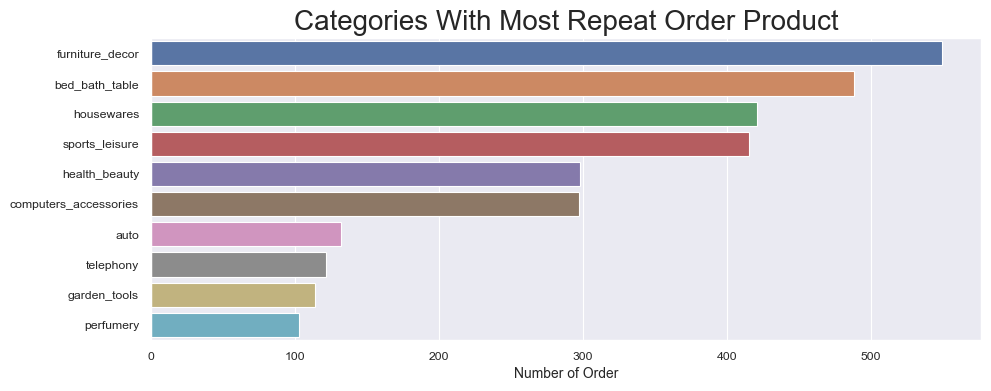

In [73]:
#Making the barplot

#Declaring the subplots
fig, ax = plt.subplots(figsize = (10,4)) 

#Making barplot out of the data
sns.barplot(data = repeat_order_per_category[:10], x = "repeat_order_item_per_category", y = "product_category_name_english", orient = "h", ax = ax)
ax.set_title("Categories With Most Repeat Order Product", fontsize = 20)
ax.set_xlabel("Number of Order", fontsize = 10)
ax.set_ylabel("")

plt.tight_layout()
plt.show()

In [ ]:
#datediff between order_approved_at and order_purchase_timestamp

In [20]:
#Checking the dtype on each column

order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99441 non-null  object
 5   order_delivered_carrier_date   99441 non-null  object
 6   order_delivered_customer_date  99441 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [75]:
#Assigning the two columns to datetime type

order["order_approved_at"] = pd.to_datetime(order["order_approved_at"],yearfirst = True)
order["order_purchase_timestamp"] = pd.to_datetime(order["order_purchase_timestamp"], yearfirst = True)

In [22]:
isinstance( order.loc[1,"order_approved_at"], dt.date)

True

In [23]:
#Checking the dtype on each column after assigning into datetime

order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99441 non-null  datetime64[ns]
 5   order_delivered_carrier_date   99441 non-null  object        
 6   order_delivered_customer_date  99441 non-null  object        
 7   order_estimated_delivery_date  99441 non-null  object        
dtypes: datetime64[ns](2), object(6)
memory usage: 6.1+ MB


In [76]:
#Removing the data that was filled with 1999-01-01 while filling the null values

#Filtering the data
order_no_nulldate = order[order["order_approved_at"]> "2000-01-01"].reset_index()

#Finding the diff between order purchase time and order approved, then making it into hour format
order_no_nulldate["response_time_hour"] = (order_no_nulldate["order_approved_at"]-order_no_nulldate["order_purchase_timestamp"])/np.timedelta64('1', "h")
order_no_nulldate["response_time_hour"].describe()

count    99281.000000
mean        10.419094
std         26.038004
min          0.000000
25%          0.215000
50%          0.343333
75%         14.580833
max       4509.180556
Name: response_time_hour, dtype: float64

In [115]:
#CHecking the average of time difference
np.average(order_no_nulldate["response_time_hour"])

10.419094301919692

In [117]:
#Using IQR to filter outlier

#Find Q1, Q3, and IQR
q1 = order_no_nulldate["response_time_hour"].quantile(0.25)
q3 = order_no_nulldate["responsedse_time_hour"].quantile(0.75)
IQR = q3-q1

#Max value as threshold, data above the max value will be deleted
max_value = q3+1.5*IQR

#sellers_response_time.loc[sellers_response_time["response_time_hour"]>max_value["response_time_hour"]]
order_cleaned = order_no_nulldate.loc[order_no_nulldate["response_time_hour"]<max_value]
order_cleaned.head()

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,response_time_hour
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,0.178333
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,30.713889
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,0.276111
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,0.298056
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1.030556


In [119]:
#Check the average after cleaning

np.average(order_cleaned["response_time_hour"])

5.204837105243694

In [130]:
#Merging the table with order_items to group it using seller_id
seller_response_time = pd.merge(order_cleaned, order_items, on="order_id")
seller_response_time.loc[:,["seller_id", "response_time_hour"]]


,seller_id,response_time_hour
0,3504c0cb71d7fa48d967e0e4c94d59d9,0.178333
1,289cdb325fb7e7f891c38608bf9e0962,30.713889
2,4869f7a5dfa277a7dca6462dcf3b52b2,0.276111
3,66922902710d126a0e7d26b0e3805106,0.298056
4,2c9e548be18521d1c43cde1c582c6de8,1.030556
...,...,...
102030,1f9ab4708f3056ede07124aad39a2554,0.194167
102031,d50d79cb34e38265a8649c383dcffd48,0.292500
102032,a1043bafd471dff536d0c462352beb48,0.131667
102033,a1043bafd471dff536d0c462352beb48,0.131667


In [184]:
#Making data that contain average response time and count order_id grouped by seller_id

#Making two data, first contain group of response time, second contain 
data1 = seller_response_time.loc[:,["seller_id", "response_time_hour"]].groupby(["seller_id"]).mean()
data2 = seller_response_time.loc[:,["seller_id", "order_id"]].groupby(["seller_id"]).count()
data2.rename(columns = {"order_id":"count_order"}, inplace = True)

#Merging the two data
result = pd.merge(data1, data2, on="seller_id")

#Showing seller_id that contain more than 100 orders sorted by fastest response time
result.loc[result["count_order"]>100].sort_values(by = "response_time_hour")

,response_time_hour,count_order
seller_id,,
de23c3b98a88888289c6f5cc1209054a,2.841395,172
bfd27a966d91cfaafdb25d076585f0da,2.878644,111
229c3efbfb0ea2058de4ccdfbc3d784a,2.879878,130
5cf13accae3222c70a9cac40818ae839,2.996597,148
95e03ca3d4146e4011985981aeb959b9,3.191127,172
...,...,...
ce27a3cc3c8cc1ea79d11e561e9bebb6,8.039499,149
f7ba60f8c3f99e7ee4042fdef03b70c4,8.307497,206
18a349e75d307f4b4cc646a691ed4216,9.642173,131


<AxesSubplot: xlabel='response_time_hour', ylabel='order_id'>

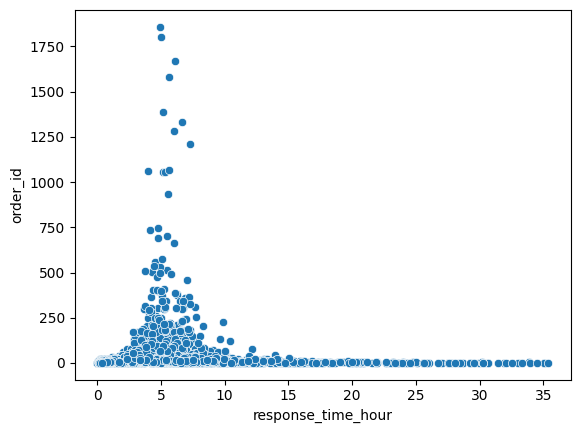

In [159]:
sns.scatterplot(result, x = "response_time_hour", y = "order_id")